# Data Analysis 

In this section we conduct a analysis of the data we need for our analysis and we end by constructing from this data the dataset we are going to use in the following steps.



In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as stats
import random


In [35]:
df = pd.read_parquet('ourdata/drifting_dataset_session_798911424.parquet')

The dataset we are starting from has the following elements:
- 'stimulus_presentation_id' = id of the stimuli
- 'unit_id' = the id of the neurons
- 'temporal_frequency' = 
- 'orientation' = 
- 'spikes_per_second' = number of spikes per second in that neuron cause by that stimulus
- 'area' = area of the brain in which the neuron is

In [36]:
df

,stimulus_presentation_id,unit_id,orientation,temporal_frequency,spikes_per_second,area
0,3798,951088664,0.0,15.0,12.489571,APN
1,3798,951088679,0.0,15.0,11.989988,APN
2,3798,951088721,0.0,15.0,12.489571,APN
3,3798,951088823,0.0,15.0,0.999166,APN
4,3798,951088862,0.0,15.0,38.967462,APN
...,...,...,...,...,...,...
396805,49432,951117127,180.0,1.0,11.490348,VISrl
396806,49432,951117252,180.0,1.0,10.990768,LP
396807,49432,951117258,180.0,1.0,2.997482,LP
396808,49432,951117264,180.0,1.0,10.491187,LP


We start our analysis by looking at if we have duplicates and nan values and if the data is of the type we need for our analysis (i.e. numerical values for all variables except the 'area')

In [37]:
print(df.duplicated().sum())

0


In [38]:
print(df.isnull().sum())

stimulus_presentation_id    0
unit_id                     0
orientation                 0
temporal_frequency          0
spikes_per_second           0
area                        0
dtype: int64


We see that only spatial_frequency and temporal_frequency contain nan values. let's see if they correspond to the same experiments all the time or we can have also some cases in which one is 0 and the other one is not. 

In [39]:
both_nan = df[df['orientation'].isna() & df['temporal_frequency'].isna()]
print(f"Rows where both are NaN: {len(both_nan)}")

Rows where both are NaN: 0


The two variables are always NaN at the same time. For our purpose this datapoints are useless so we can delete them.

In [40]:
df = df.dropna(subset=['orientation', 'temporal_frequency'])

In [41]:
print(df.dtypes)

stimulus_presentation_id      int64
unit_id                       int64
orientation                 float64
temporal_frequency          float64
spikes_per_second           float64
area                         object
dtype: object


In [42]:
print(df.describe())

       stimulus_presentation_id       unit_id    orientation  \
count             378168.000000  3.781680e+05  378168.000000   
mean               29278.930259  9.511045e+08     157.481913   
std                18698.626466  8.430695e+03     103.091520   
min                 3798.000000  9.510887e+08       0.000000   
25%                 3958.000000  9.510975e+08      90.000000   
50%                31119.000000  9.511050e+08     135.000000   
75%                49277.000000  9.511121e+08     270.000000   
max                49432.000000  9.511176e+08     315.000000   

       temporal_frequency  spikes_per_second  
count       378168.000000      378168.000000  
mean             5.933572           8.886897  
std              5.085390          11.298671  
min              1.000000           0.499568  
25%              2.000000           1.498771  
50%              4.000000           4.995828  
75%              8.000000          11.490348  
max             15.000000         157.868180  


We are focusing on the drifting_gratings as stimuli. 
Each drifting_gratings has two main characteristics which are orientation and temporal_frequency. 

Let's look at the possible values this features can take.

In [43]:
print("STATIC GRATINGS")
print('Possible values:')
print(' - Orientation: ', df['orientation'].unique())
print(' - Temporal_frequency: ', df['temporal_frequency'].unique())

STATIC GRATINGS
Possible values:
 - Orientation:  [  0. 180.  45.  90. 270. 315. 135. 225.]
 - Temporal_frequency:  [15.  2.  1.  8.  4.]


Let's now see how many datapoints we have of each values of temporal frequency, orientation and area.

<Axes: xlabel='temporal_frequency', ylabel='count'>

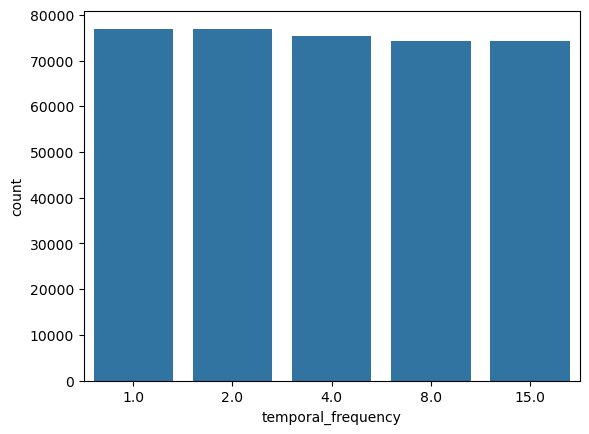

In [44]:
sns.countplot(x='temporal_frequency', data=df)

<Axes: xlabel='orientation', ylabel='count'>

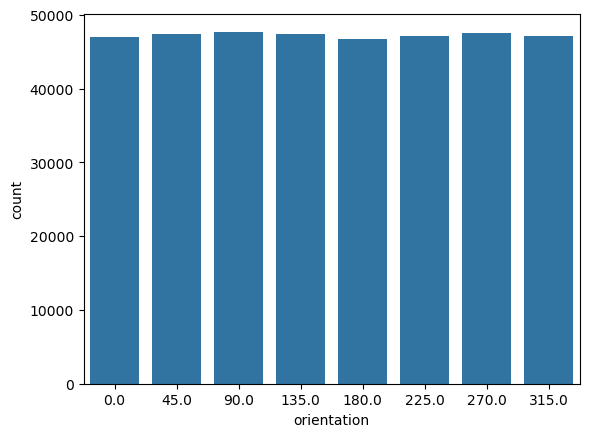

In [45]:
sns.countplot(x='orientation', data=df)

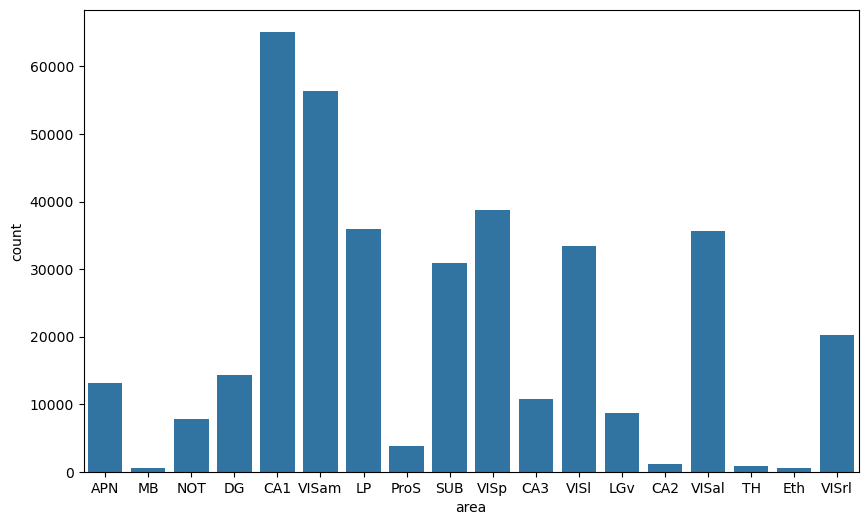

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(x='area', data=df)
plt.show()

## Normalization

As we can see we have a almost equal number of counts for temporal frequecny and orientation, while for the area we have some that appear more frequently.

Let's now look at the distribution of the spikes per second 

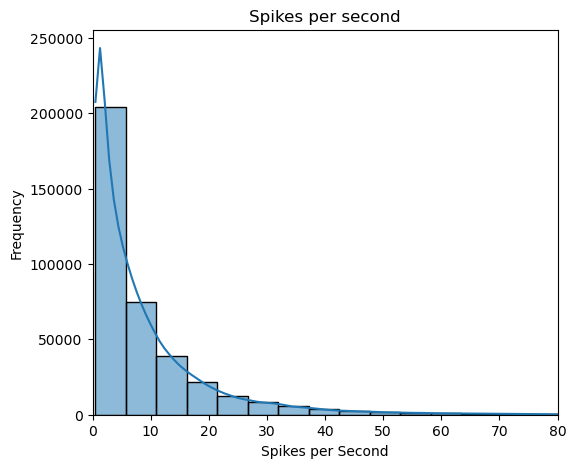

In [47]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(df['spikes_per_second'], kde=True, bins=30, ax=ax)

ax.set_title("Spikes per second")
ax.set_xlabel("Spikes per Second")
ax.set_ylabel("Frequency")
ax.set_xlim(left=0, right=80)  

plt.show()


We see that the distribution is highly skewed to the left. This means that we have lots of neurons which have a few number of spikes per second. 

In order to reduce this we try to apply log tranformation, square root transformation and box-cox transformation.

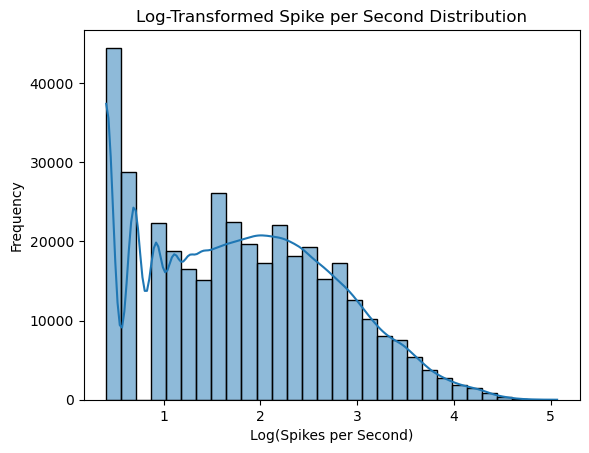

In [48]:
df["log_spikes"] = np.log1p(df["spikes_per_second"])  
sns.histplot(df["log_spikes"], kde=True, bins=30)
plt.title("Log-Transformed Spike per Second Distribution")
plt.xlabel("Log(Spikes per Second)")
plt.ylabel("Frequency")
plt.show()


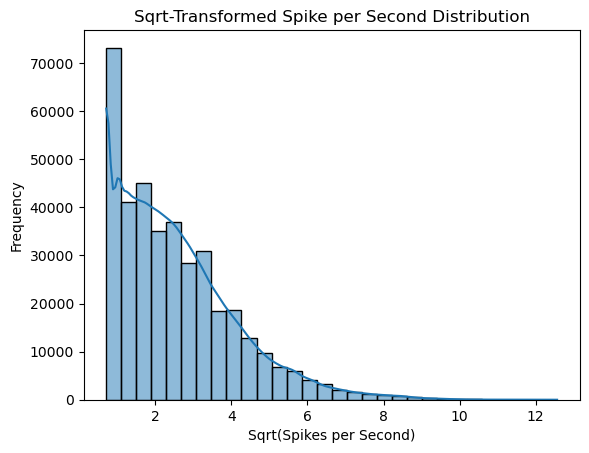

In [49]:
df["sqrt_spikes"] = np.sqrt(df["spikes_per_second"])
sns.histplot(df["sqrt_spikes"], kde=True, bins=30)
plt.title("Sqrt-Transformed Spike per Second Distribution")
plt.xlabel("Sqrt(Spikes per Second)")
plt.ylabel("Frequency")
plt.show()

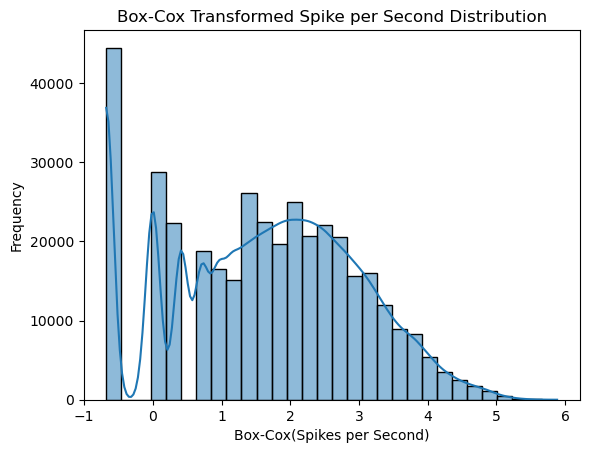

In [50]:
df["boxcox_spikes"], _ = stats.boxcox(df["spikes_per_second"])
sns.histplot(df["boxcox_spikes"], kde=True, bins=30)
plt.title("Box-Cox Transformed Spike per Second Distribution")
plt.xlabel("Box-Cox(Spikes per Second)")
plt.ylabel("Frequency")
plt.show()


We notice that in the cases of log and box-cox transformation we have a better distribution that almost looks like a normal. 

Let's now look better at the structure of the data using a boxplot.

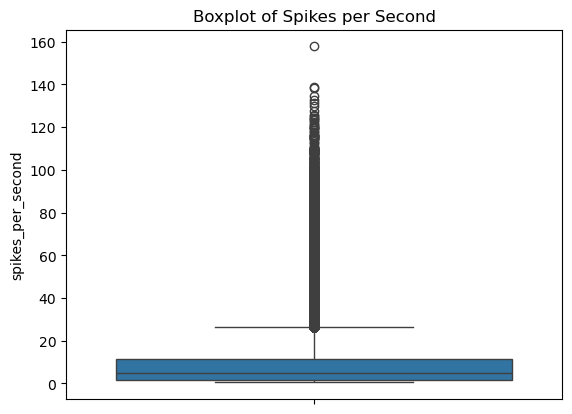

In [51]:
sns.boxplot(y=df["spikes_per_second"])
plt.title("Boxplot of Spikes per Second")
plt.show()


As we can see we have a big concentration of points in the range 0-20 and lots of outliers with larger values.

## Correlation

We now look at the correlation between temporal frequency and spikes per second.

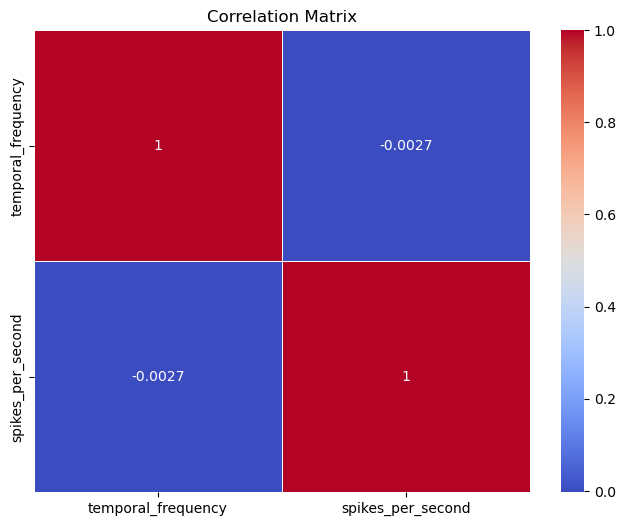

In [52]:
correlation_matrix = df[['temporal_frequency', 'spikes_per_second']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


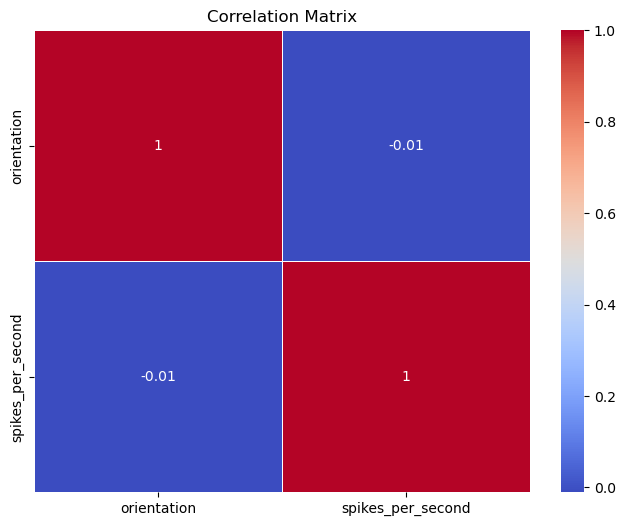

In [53]:
correlation_matrix = df[['orientation', 'spikes_per_second']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


As we can see we don't have direct linear relationship between the orientation and the spikes per second and between the temporal frequency and the spikes per second. What we want to prove is in fact is that a certain orientation and temporal frequency causes a different effect in each part of the brain.

## analysis of areas structure

We now focus on analysis the areas we will consider. What we want to see in particular is if each neuron of the area has similar reaction to a certain 
stimulus.

We do so by picking 4 areas and plot the values of spike per second for each neuron in the case of 4 different stimulus.

/var/folders/l5/l2yq9xlj55l1p5qsn5c6n5wh0000gn/T/ipykernel_59556/140786021.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 4)


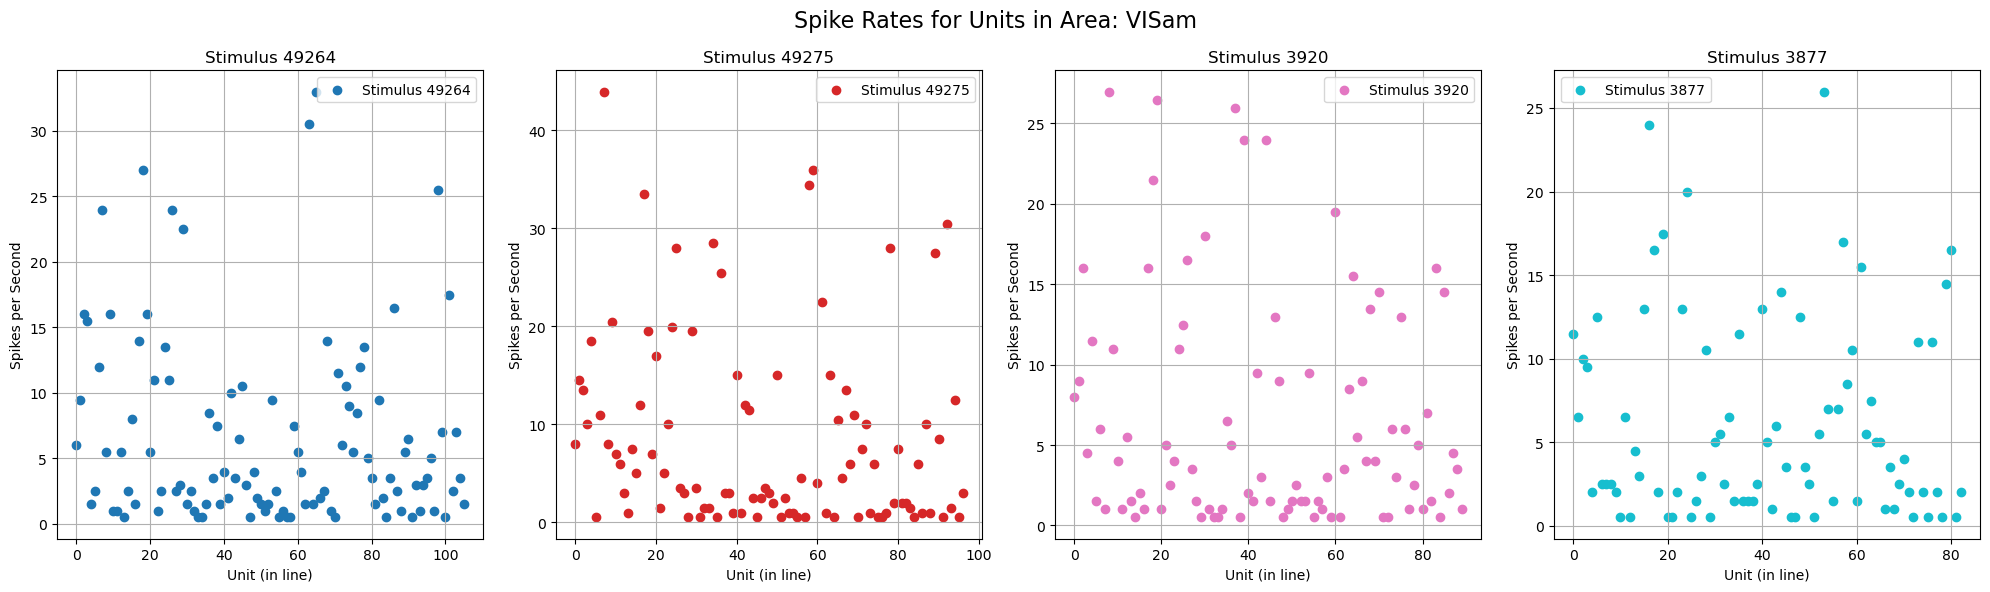

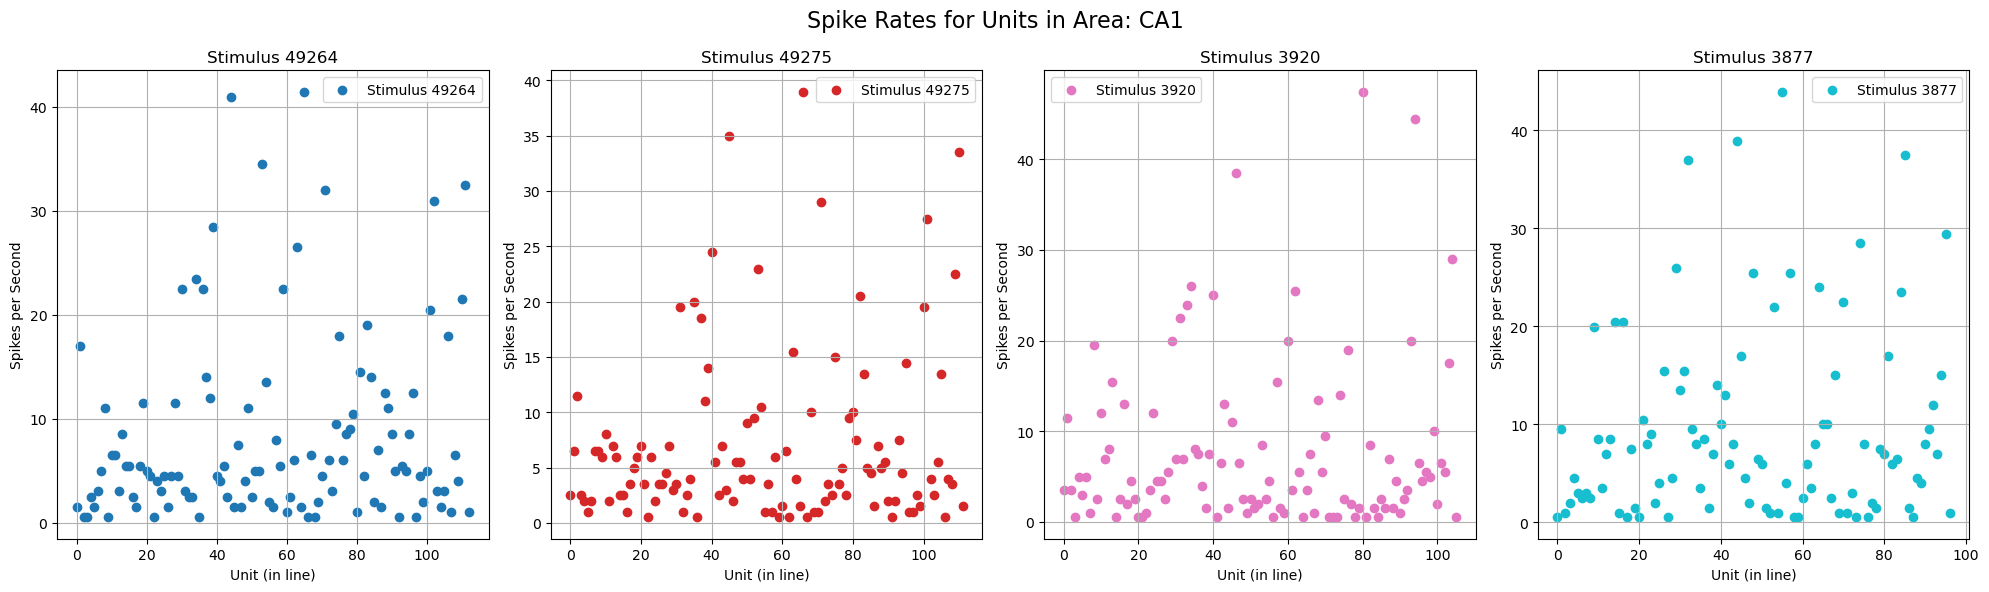

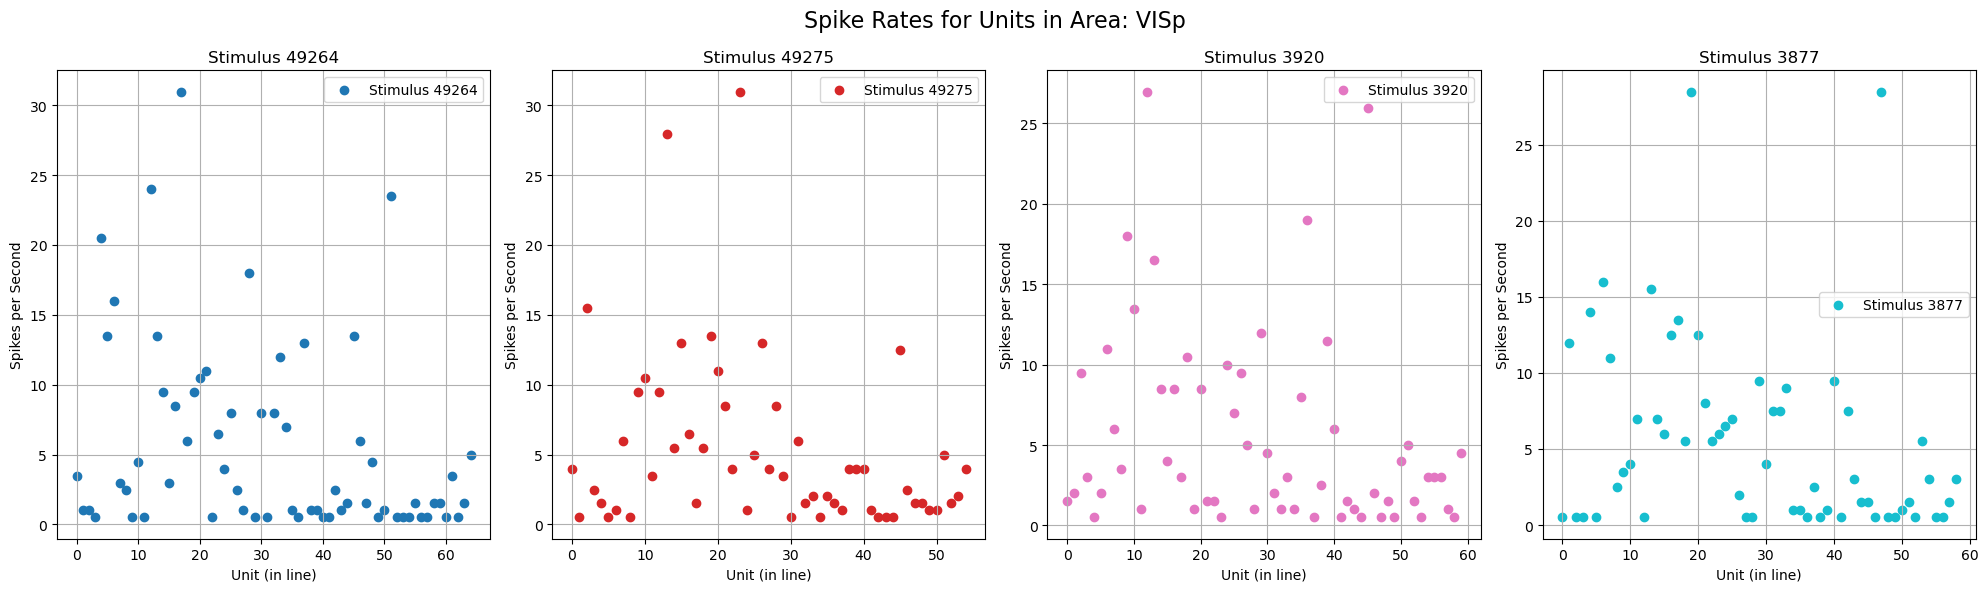

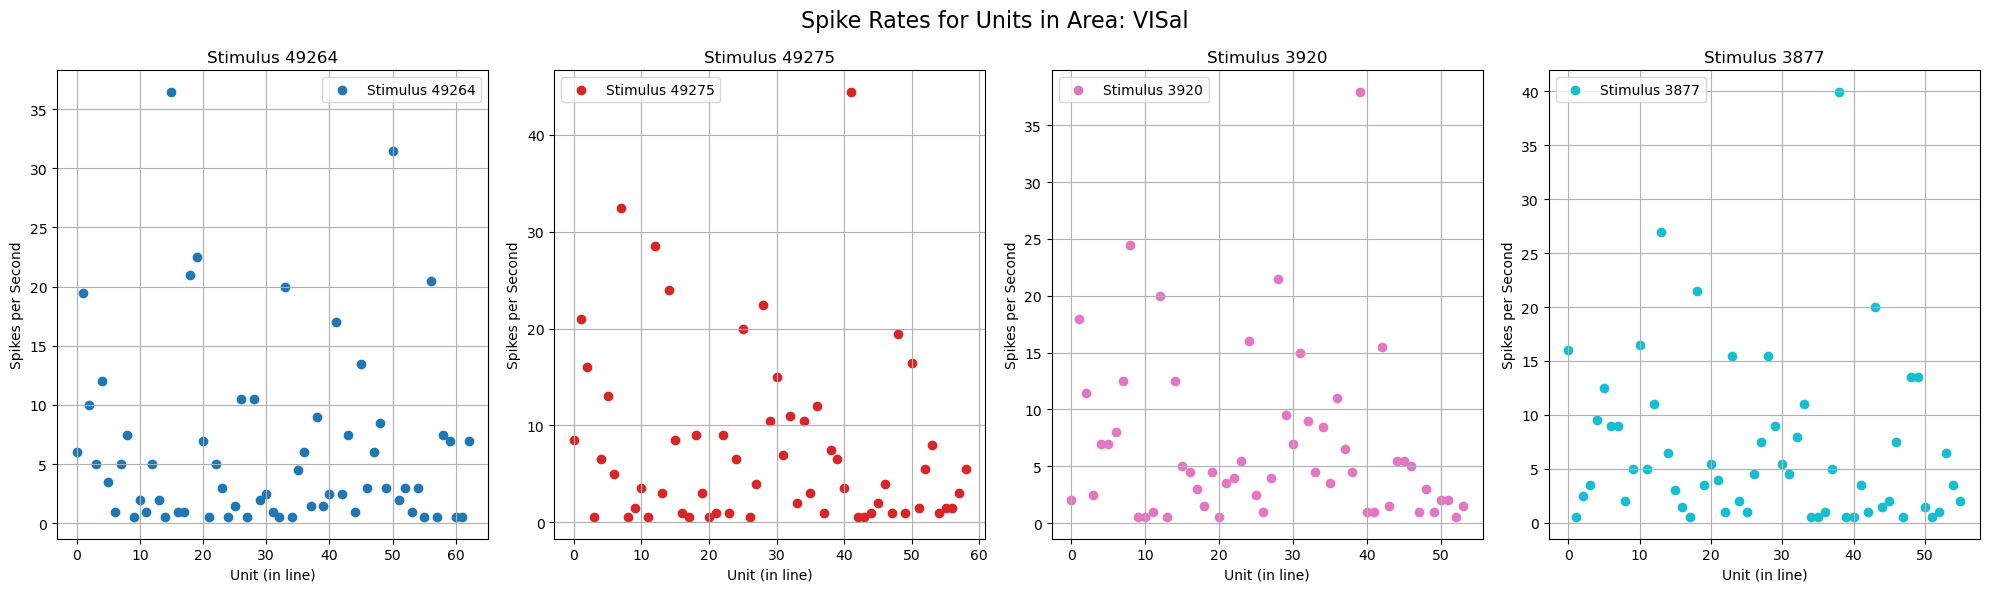

In [54]:
random_areas = ['VISam', 'CA1', 'VISp', 'VISal']

colors = plt.cm.get_cmap('tab10', 4)  

for i, area in enumerate(random_areas):
    stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
    random_stimuli = [49264, 49275, 3920, 3877]
    area_data = df[(df['area'] == area) & (df['stimulus_presentation_id'].isin(random_stimuli))]

    fig, axes = plt.subplots(1, 4, figsize=(20, 6))  
    
    for j, stimulus in enumerate(random_stimuli):
        stimulus_data = area_data[area_data['stimulus_presentation_id'] == stimulus]
       
        axes[j].scatter(range(len(stimulus_data)), stimulus_data['spikes_per_second'],
                        color=colors(j), label=f'Stimulus {stimulus}')
        
        axes[j].set_title(f'Stimulus {stimulus}')
        axes[j].set_xlabel('Unit (in line)')
        axes[j].set_ylabel('Spikes per Second')
        axes[j].grid(True)
        axes[j].legend()

    fig.suptitle(f'Spike Rates for Units in Area: {area}', fontsize=16)

    plt.tight_layout()

    plt.show()


As we can see the spikes per second of each neuron within the same area are very different.

Our analysis will in fact be directed towards determing if an area is active or not. The way to determine this is set by us in the following way: if more than the 30% of the neurons in the area has the values of simulus_per_second larger than 10 then the area is considered active.

Now we want to verify something fundamental for our analysis: if different stimulus activate different areas of the brain. 

Let's consider 3 stimulus at random and see which areas are active in the 4 cases.

In [55]:
stimuli = [49387, 49417, 3857, 31102]

In [56]:
i = stimuli[0]
for area in df['area'].unique():
        stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
        area_data = df[(df['area'] == area) & (df['stimulus_presentation_id']==i)]

        units = area_data['unit_id'].unique()
        units_with_high_spikes = area_data[area_data['spikes_per_second'] > 10]['unit_id'].unique()

        percentage = len(units_with_high_spikes) / len(units) * 100

        if percentage >= 30:
            print(f"Area: {area} - active")
        else:
            print(f"Area: {area} - inactive")

Area: APN - active
Area: MB - active
Area: NOT - active
Area: DG - active
Area: CA1 - active
Area: VISam - active
Area: LP - active
Area: ProS - active
Area: SUB - active
Area: VISp - inactive
Area: CA3 - active
Area: VISl - inactive
Area: LGv - active
Area: CA2 - inactive
Area: VISal - inactive
Area: TH - active
Area: Eth - active
Area: VISrl - active


In [57]:
i = stimuli[1]
for area in df['area'].unique():
        stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
        area_data = df[(df['area'] == area) & (df['stimulus_presentation_id']==i)]

        units = area_data['unit_id'].unique()
        units_with_high_spikes = area_data[area_data['spikes_per_second'] > 10]['unit_id'].unique()

        percentage = len(units_with_high_spikes) / len(units) * 100

        if percentage >= 30:
            print(f"Area: {area} - active")
        else:
            print(f"Area: {area} - inactive")

Area: APN - active
Area: MB - active
Area: NOT - active
Area: DG - active
Area: CA1 - active
Area: VISam - active
Area: LP - active
Area: ProS - active
Area: SUB - active
Area: VISp - inactive
Area: CA3 - active
Area: VISl - active
Area: LGv - active
Area: CA2 - active
Area: VISal - active
Area: TH - active
Area: Eth - active
Area: VISrl - inactive


In [58]:
i = stimuli[2]
for area in df['area'].unique():
        stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
        area_data = df[(df['area'] == area) & (df['stimulus_presentation_id']==i)]

        units = area_data['unit_id'].unique()
        units_with_high_spikes = area_data[area_data['spikes_per_second'] > 10]['unit_id'].unique()

        percentage = len(units_with_high_spikes) / len(units) * 100

        if percentage >= 30:
            print(f"Area: {area} - active")
        else:
            print(f"Area: {area} - inactive")

Area: APN - active
Area: MB - inactive
Area: NOT - active
Area: DG - inactive
Area: CA1 - inactive
Area: VISam - inactive
Area: LP - inactive
Area: ProS - inactive
Area: SUB - inactive
Area: VISp - inactive
Area: CA3 - active
Area: VISl - inactive
Area: LGv - active
Area: CA2 - inactive
Area: VISal - inactive
Area: TH - active
Area: Eth - active
Area: VISrl - inactive


In [59]:
i = stimuli[3]
for area in df['area'].unique():
        stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
        area_data = df[(df['area'] == area) & (df['stimulus_presentation_id']==i)]

        units = area_data['unit_id'].unique()
        units_with_high_spikes = area_data[area_data['spikes_per_second'] > 10]['unit_id'].unique()

        percentage = len(units_with_high_spikes) / len(units) * 100

        if percentage >= 30:
            print(f"Area: {area} - active")
        else:
            print(f"Area: {area} - inactive")

Area: APN - active
Area: MB - active
Area: NOT - active
Area: DG - inactive
Area: CA1 - inactive
Area: VISam - inactive
Area: LP - inactive
Area: ProS - inactive
Area: SUB - active
Area: VISp - inactive
Area: CA3 - inactive
Area: VISl - inactive
Area: LGv - active
Area: CA2 - inactive
Area: VISal - inactive
Area: TH - active
Area: Eth - active
Area: VISrl - inactive


As we can see in the four cases we have four different situations. 

In particular, let's see the case of the area LGd for the four stimuli.

/var/folders/l5/l2yq9xlj55l1p5qsn5c6n5wh0000gn/T/ipykernel_59556/2998519832.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 4)


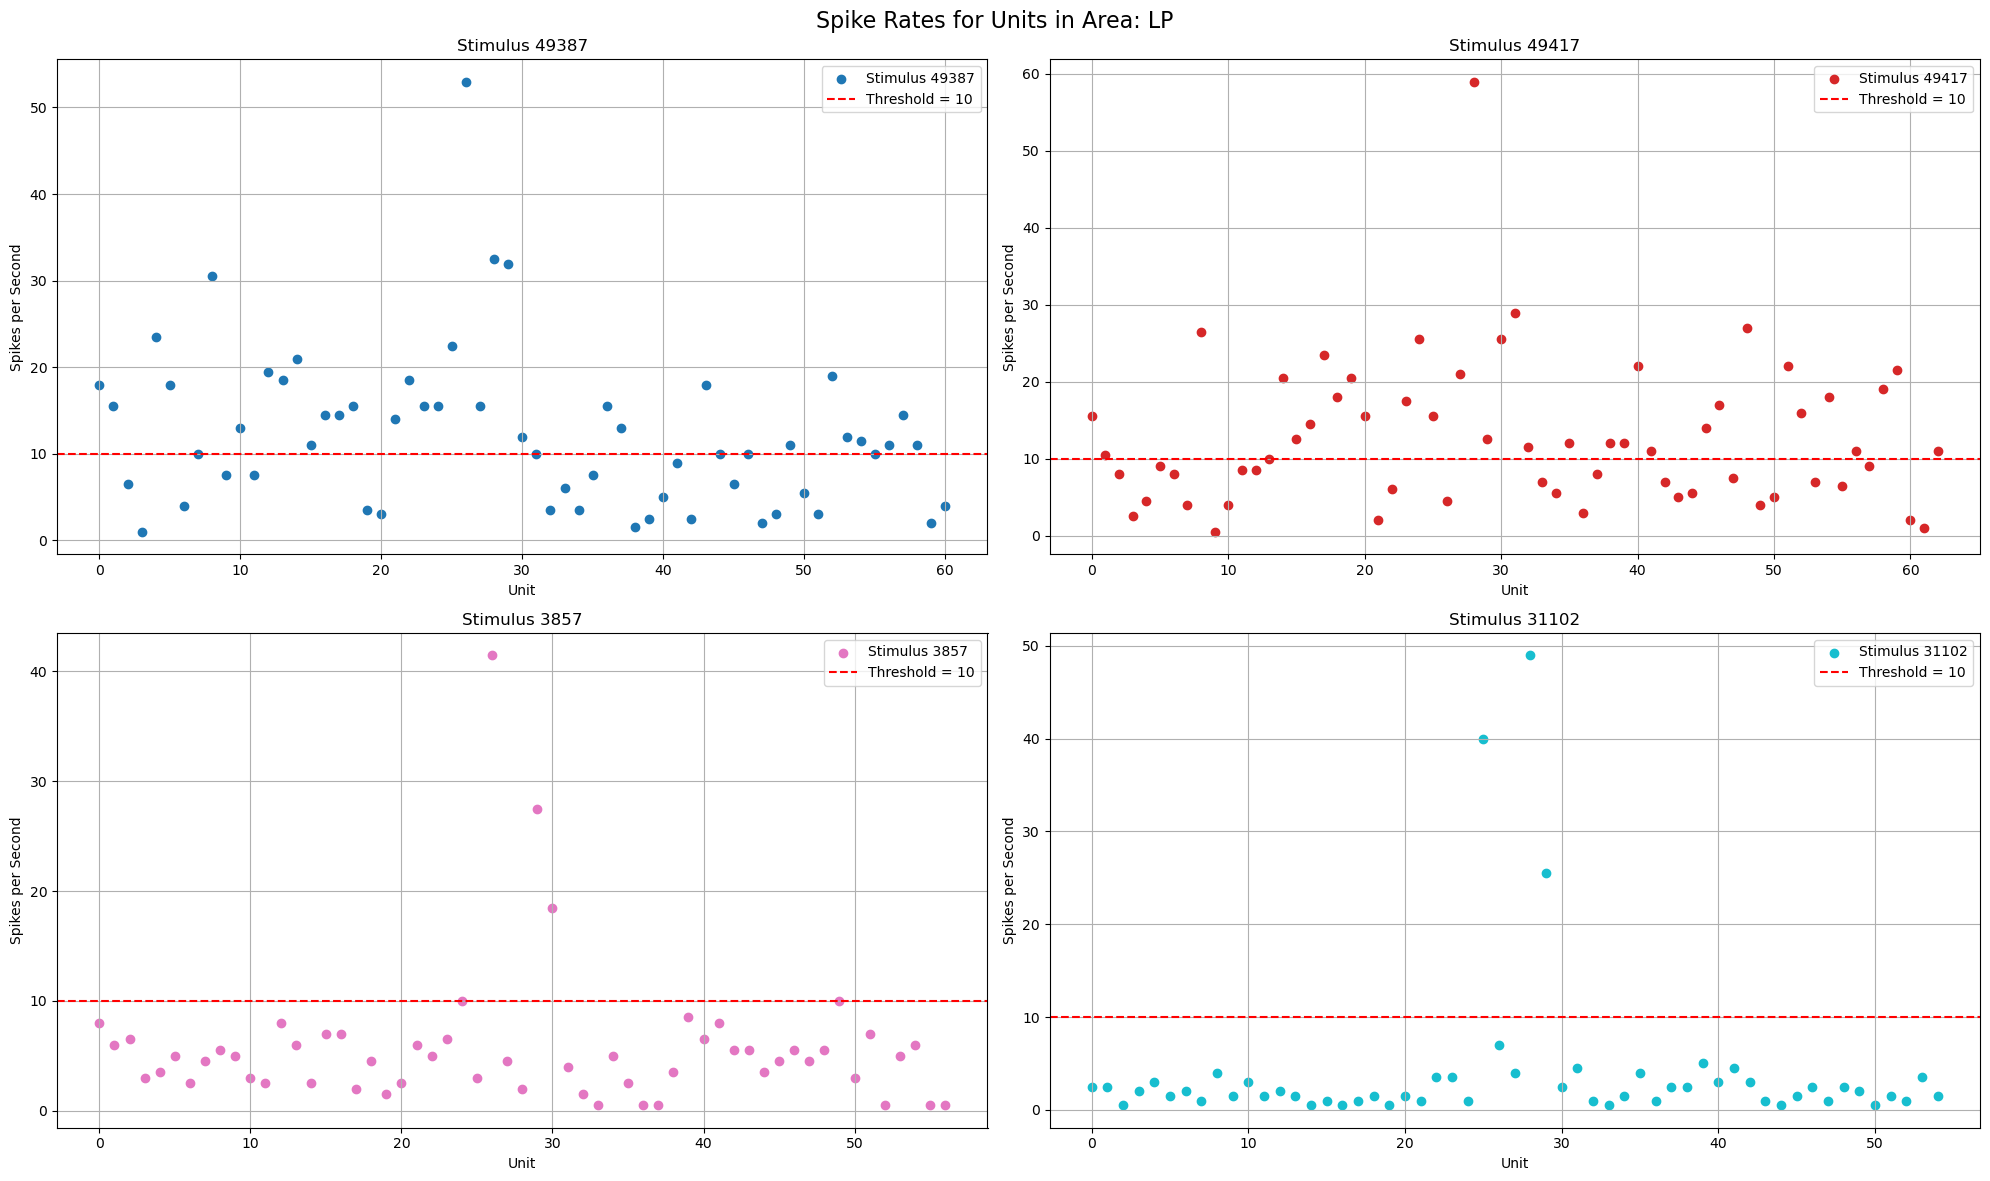

In [60]:
colors = cm.get_cmap('tab10', 4) 

fig, axes = plt.subplots(2, 2, figsize=(20, 12))  

axes = axes.flatten()

for j, stimulus in enumerate(stimuli):

    stimulus_data = df[(df['area'] == 'LP') & (df['stimulus_presentation_id'] == stimulus)]
   
    axes[j].scatter(range(len(stimulus_data)), stimulus_data['spikes_per_second'],
                    color=colors(j / 4), label=f'Stimulus {stimulus}')
    
    axes[j].axhline(y=10, color='red', linestyle='--', linewidth=1.5, label='Threshold = 10')
    
    axes[j].set_title(f'Stimulus {stimulus}')
    axes[j].set_xlabel('Unit')
    axes[j].set_ylabel('Spikes per Second')
    axes[j].grid(True)
    axes[j].legend()

fig.suptitle('Spike Rates for Units in Area: LP', fontsize=16)

plt.tight_layout()
plt.show()


As we can see in the first two cases, where LGd is defined as active, most of the neurons have the value of spike_per_second above the threshold we chose. 
In the second case instead we have the most of the neurons below the line, which makes sense since in this cases LGd where judged as inactive.

Let's proceed by creating the dataset we are going to use in the following steps.

In [61]:
#find the areas with the highest number of units
areas = df['area'].unique()
area_units = {}
for area in areas:
    area_units[area] = len(df[df['area'] == area]['unit_id'].unique())

area_units = {k: v for k, v in sorted(area_units.items(), key=lambda item: item[1], reverse=True)}
print(area_units)


{'VISam': 135, 'CA1': 134, 'VISp': 94, 'VISal': 89, 'VISl': 78, 'LP': 65, 'SUB': 59, 'VISrl': 47, 'DG': 31, 'APN': 25, 'CA3': 21, 'NOT': 16, 'LGv': 16, 'ProS': 9, 'CA2': 2, 'TH': 2, 'MB': 1, 'Eth': 1}


In [62]:
#find stimuli for VISam with higest number of active units
area = 'LP'
stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
stimuli_units = {}
for i in stimuli_in_area:
    area_data = df[(df['area'] == area) & (df['stimulus_presentation_id'] == i)]
    units = area_data['unit_id'].unique()
    units_with_high_spikes = area_data[area_data['spikes_per_second'] < 10]['unit_id'].unique()
    percentage = len(units_with_high_spikes) / len(units) * 100
    stimuli_units[i] = percentage

stimuli_units = {k: v for k, v in sorted(stimuli_units.items(), key=lambda item: item[1], reverse=True)}
print(stimuli_units)


{3857: 94.73684210526315, 31102: 94.54545454545455, 3989: 94.33962264150944, 3850: 93.33333333333333, 3956: 93.10344827586206, 3972: 93.10344827586206, 31001: 93.10344827586206, 31129: 92.98245614035088, 3969: 92.85714285714286, 3936: 91.80327868852459, 3896: 91.66666666666666, 31035: 91.52542372881356, 31095: 91.52542372881356, 3888: 91.37931034482759, 3966: 91.37931034482759, 3997: 91.37931034482759, 3935: 91.22807017543859, 3938: 91.22807017543859, 31081: 91.22807017543859, 3897: 91.07142857142857, 3902: 91.07142857142857, 31003: 91.07142857142857, 3959: 90.56603773584906, 31180: 90.47619047619048, 3837: 90.38461538461539, 3899: 90.38461538461539, 31097: 90.32258064516128, 49254: 90.32258064516128, 3871: 90.1639344262295, 3990: 90.1639344262295, 31099: 90.1639344262295, 49225: 90.1639344262295, 49274: 90.1639344262295, 3853: 90.0, 3964: 90.0, 3973: 90.0, 3977: 90.0, 3987: 90.0, 31186: 90.0, 49277: 90.0, 3903: 89.83050847457628, 3975: 89.83050847457628, 3864: 89.65517241379311, 3967:

##  Creation of dataset for the analysis

We create a dataset with all the combinations of stimuli and units adding a new column 'active' which takes value 1 if the unit is active and 0 if it's not.

In [63]:
def determine_active(group):
    total_units = group['unit_id'].nunique()  
    active_units = group[group['spikes_per_second'] > 10]['unit_id'].nunique()  
    
    if total_units == 0:
        return 0
    
    return 1 if (active_units / total_units) * 100 >= 30 else 0

In [64]:
new_df = df[['stimulus_presentation_id', 'area', 'temporal_frequency', 'orientation', 'spikes_per_second', 'unit_id']]

grouped_df = new_df.groupby(['stimulus_presentation_id', 'area']).apply(determine_active).reset_index(name='active')

final_df = grouped_df.merge(new_df[['stimulus_presentation_id', 'area', 'temporal_frequency', 'orientation']].drop_duplicates(),
                            on=['stimulus_presentation_id', 'area'], how='left')

final_df = final_df[['stimulus_presentation_id', 'area', 'temporal_frequency', 'orientation', 'active']]


In [65]:
final_df

,stimulus_presentation_id,area,temporal_frequency,orientation,active
0,3798,APN,15.0,0.0,1
1,3798,CA1,15.0,0.0,1
2,3798,CA2,15.0,0.0,1
3,3798,CA3,15.0,0.0,0
4,3798,DG,15.0,0.0,1
...,...,...,...,...,...
10795,49432,VISal,1.0,180.0,1
10796,49432,VISam,1.0,180.0,1
10797,49432,VISl,1.0,180.0,0
10798,49432,VISp,1.0,180.0,1


In [66]:
final_df.to_parquet('ourdata/df_drifting_session_798911424.parquet', index=False)    